Epoch 0 | Generator Loss: 0.8699 | Discriminator Loss: 1.1410


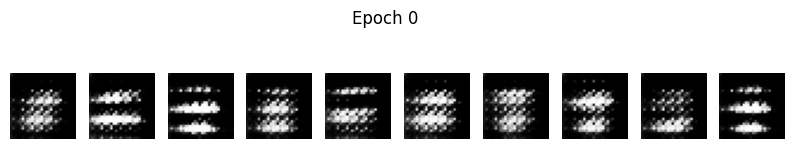

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess the data
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(-1, 28, 28, 1).astype("float32")
train_images = (train_images - 127.5) / 127.5  # Normalize to [-1, 1]

BUFFER_SIZE = 60000
BATCH_SIZE = 128

# Ensure batch size is fixed to prevent shape mismatch errors
train_dataset = tf.data.Dataset.from_tensor_slices(train_images) \
    .shuffle(BUFFER_SIZE) \
    .batch(BATCH_SIZE, drop_remainder=True)

# Generator Model
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((7, 7, 256)))

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

# Discriminator Model
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

# Loss and optimizers
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

generator = make_generator_model()
discriminator = make_discriminator_model()

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Training step
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
        disc_loss = cross_entropy(tf.ones_like(real_output), real_output) + \
                    cross_entropy(tf.zeros_like(fake_output), fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

# Generate and plot images
def generate_and_plot_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(10, 2))
    for i in range(predictions.shape[0]):
        plt.subplot(1, predictions.shape[0], i+1)
        plt.imshow((predictions[i, :, :, 0] + 1) / 2.0, cmap='gray')
        plt.axis('off')
    plt.suptitle(f"Epoch {epoch}")
    plt.show()

# Train function
def train(dataset, epochs):
    seed = tf.random.normal([10, 100])
    for epoch in range(epochs):
        for image_batch in dataset:
            g_loss, d_loss = train_step(image_batch)
        if epoch % 5 == 0:
            print(f"Epoch {epoch} | Generator Loss: {g_loss:.4f} | Discriminator Loss: {d_loss:.4f}")
            generate_and_plot_images(generator, epoch, seed)

# Run training
train(train_dataset, epochs=30)
